#1. Initial Setting

In [1]:
import numpy as np
Nsub = 50
TimePeriod = 100
SamplePath = 50 * Nsub
lower_bound = 1e-4
theta2 = np.array([0.94,0.9919,0.0827])

# theta1 = np.array([3, -1, -2, 0,9, 2.5,
#                    4, -2, -1,1, 9.5, 3])

theta1 = np.array([(2.9+9.7)/2, -1.5,-1, -0.4,   12.5,
                   (1.2+5.2)/2,-0.7, -0.3,-0.2,  7.7])
#theta1 = theta1/np.max(np.abs(theta1))#np.linalg.norm(theta1)
print(theta1)

dim_sh = 2
dim_z = 2
dim_so = 4*4
dim_a = 3
dim_discrete = 100

old_sh = np.arange(dim_sh,dtype = int)
old_z = np.arange(dim_z,dtype = int)
old_so = np.arange(dim_so,dtype = int) #old_n1*3+old_n2
old_n1 = old_so//4
old_n2 = old_so%4
old_a1 = np.arange(dim_a,dtype = int)
old_a2 = np.arange(dim_a,dtype = int)
old_x = np.linspace(0,1,num=dim_discrete)

[ 6.3 -1.5 -1.  -0.4 12.5  3.2 -0.7 -0.3 -0.2  7.7]


#2. POSG Initial Function

##2.1 Dynamic

In [2]:
######P(ni'|ni,ai)-->action*(ni+nj)*(ni+nj)-->3*9*9######
dy_a1so = np.zeros([dim_a,4,4])
dy_a2so = np.zeros([dim_a,4,4])
for ai in range(dim_a):
  for ni_old in range(4):
    for ni_new in range(4):
      if ni_new == ni_old + ai-1:
        dy_a1so[ai,ni_old,ni_new] = 1
        dy_a2so[ai,ni_old,ni_new] = 1
dy_a1so[0,0,0] = 1
dy_a2so[0,0,0] = 1
dy_a1so[2,3,3] = 1
dy_a2so[2,3,3] = 1
#print(dy_a1so,dy_a2so)
dy_a1so = (dy_a1so[:,old_n1,:])[:,:,old_n1]
dy_a2so = (dy_a2so[:,old_n2,:])[:,:,old_n2]
# print(dy_a1so,'\n',dy_a2so)
# print(dy_a1so.shape,dy_a2so.shape)

######P(z',sh'|sh)-->sh_old*(sh_new)*(z_new)-->2*2*2######

def DynamicPartial(theta2):
  trans = np.zeros([dim_sh,dim_sh]) #sh_old*sh_new: 2*2
  obser = np.zeros([dim_sh,dim_z])  #sh_new*z_new: 2*2
  dy_trob = np.zeros([dim_sh,dim_sh,dim_z])#sh_old*sh_new*z_new: 2*2*2

  trans_val = theta2[0:2]
  obser_val = theta2[-1]

  trans[0,0],trans[1,1] = trans_val[0],trans_val[1]
  trans[0,1],trans[1,0] = 1-trans[0,0],1-trans[1,1]
  obser[0,0] = obser[1,1] = 1-obser_val
  obser[0,1] = obser[1,0] = obser_val

  dy_trob = np.stack([trans,trans],axis=2)*np.stack([obser,obser],axis=0)
  return trans,obser,dy_trob
trans,obser,dy_trob = DynamicPartial(theta2)
# print(trans,obser)
# for sh_old in range(dim_sh):
#   for sh_new in range(dim_sh):
#     for z_new in range(dim_z):
#       print(dy_trob[sh_old,sh_new,z_new],trans[sh_old,sh_new]*obser[sh_new,z_new])

##2.2 Reward

In [3]:
import itertools
######r(x,so,ai)-->belief*(ni+nj)*actioni-->50*9*3######
def RewardPartial(theta1,num=dim_discrete):
  rd1_sh = np.zeros([dim_sh,dim_so,dim_a])
  rd2_sh = np.zeros([dim_sh,dim_so,dim_a])

  rd1_bf = np.zeros([num,dim_so,dim_a])
  rd2_bf = np.zeros([num,dim_so,dim_a])  
  for sh,ai in itertools.product(range(dim_sh),range(dim_a)):
    rd1_sh[sh,:,ai] = old_n1*(theta1[0] + old_n1*(sh==0)*theta1[1] + old_n1*(sh==1) *theta1[2] + old_n2*theta1[3] ) -(ai==2) *theta1[4]
    rd2_sh[sh,:,ai] = old_n2*(theta1[5]+ old_n2*(sh==0)*theta1[6] + old_n2*(sh==1) *theta1[7] + old_n1*theta1[8] ) -(ai==2) *theta1[9]
  
  xold = np.linspace(0,1,num=num)
  for so,ai in itertools.product(range(dim_so),range(dim_a)):
    rd1_bf[:,so,ai] = xold * rd1_sh[0,so,ai] + (1-xold) * rd1_sh[1,so,ai]
    rd2_bf[:,so,ai] = xold * rd2_sh[0,so,ai] + (1-xold) * rd2_sh[1,so,ai]
  # xold = np.stack([xold for i in range(dim_so)],axis=1)
  # xold = np.stack([xold for i in range(dim_a)],axis=2)
  return rd1_bf,rd2_bf,[rd1_sh,rd2_sh]
#print(RewardPartial(theta1))

##2.3 SigmaLambda

In [4]:
def SigmaLambda(theta2,xold = old_x,znew=old_z,num=dim_discrete,T=None):
  _,_,dytrob = DynamicPartial(theta2)
  if T==None: #generate function for Q value iteration
    xold = np.linspace(0,1,num=num)
    znew = np.arange(dim_z,dtype= int)
    sigma = np.zeros([num,dim_z]) # x_old,z_new
    xnew = np.zeros([num,dim_z])  # x_old,z_new

    for z_new in znew:
      xnew_temp = dytrob[0,0,z_new]*xold + dytrob[1,0,z_new]*(1-xold)
      sigma[:,z_new] = xnew_temp + dytrob[0,1,z_new]*xold + dytrob[1,1,z_new]*(1-xold)
      xnew[:,z_new] = xnew_temp/sigma[:,z_new]

  elif T==1: #generate data set
    #sigma = np.zeros(len(xold))
    #xnew = np.zeros(len(xold))
    xnew_temp = dytrob[0,0,znew]*xold + dytrob[1,0,znew]*(1-xold)
    sigma = xnew_temp + dytrob[0,1,znew]*xold + dytrob[1,1,znew]*(1-xold)
    xnew = xnew_temp/sigma

  else: # recover process
    sigma = np.zeros([T,len(xold)]) #T,N
    xnew = np.zeros([T+1,len(xold)]) #T+1, N
    xnew[0] = xold
    for t in range(T):
      z_new = znew[t+1]
      x_old = xnew[t]
      xnew_temp = dytrob[0,0,z_new]*x_old + dytrob[1,0,z_new]*(1-x_old)
      sigma[t] = xnew_temp + dytrob[0,1,z_new]*x_old + dytrob[1,1,z_new]*(1-x_old)
      xnew[t+1] = xnew_temp/sigma[t]
  
  belief_f = np.floor(xnew*(num-1))/(num-1)
  belief_c = np.ceil(xnew*(num-1))/(num-1)
  iterpolate = np.zeros(belief_f.shape)
  iter_n0 = np.where((belief_f-belief_c)!=0)
  iterpolate[iter_n0] = (xnew-belief_c)[iter_n0]/(belief_f-belief_c)[iter_n0]   

  return sigma,xnew,[iterpolate, np.int_(belief_f*(num-1)),np.int_(belief_c*(num-1))]   

#SigmaLambda(theta2) 

##2.4 ValueIteration

In [5]:
from scipy.special import logsumexp
from scipy.special import softmax

def ValuePartial(theta1,theta2 = theta2,num=dim_discrete,beta=0.9,gamma=0.5772,inner=1e-3,outer=1e-3):
  rd1_bf,rd2_bf,_ = RewardPartial(theta1,num=num)
  sigma,xnew,[it,bf,bc] = SigmaLambda(theta2,num=num) #xold,znew
  
  it = np.stack([np.stack([it for so_new in range(dim_so)],axis=2) for a_new in range(dim_a)],axis=3)
  si = np.stack([sigma for so_new in range(dim_so)],axis=2)

  Q1_new = np.zeros([num,dim_so,dim_a]) # 50*9*3
  Q2_new = np.zeros([num,dim_so,dim_a])
  
  pi1_new = np.ones([num,dim_so,dim_a])/dim_a
  #pi2_new = np.ones([num,dim_so,dim_a])/dim_a
  pi2_old = pi1_new.copy()

  for ol in range(1000):
    pi1_old = pi1_new.copy()
    for il in range(1000):
      Q2_old = Q2_new.copy()

      #Vbar2 #xnew, so_new--> xold,znew,so_new
      Vbar2 = gamma + logsumexp(it*Q2_old[bf,:,:] + (1-it)*Q2_old[bc,:,:],axis=3) #xold,znew,so_new ,(ai)
      Vbar2 = np.sum(si * Vbar2,axis=1) #xold, (znew),so_new

      for a2,so_old in itertools.product(range(dim_a),range(dim_so)):
        Q2_temp = np.zeros([dim_a,dim_so,num]) #a1,so_new,xold
        for a1,so_new in itertools.product(range(dim_a),range(dim_so)):
          Q2_temp[a1,so_new] = Vbar2[:,so_new]*dy_a1so[a1,so_old,so_new]*dy_a2so[a2,so_old,so_new]*pi1_old[:,so_old,a1]
        Q2_new[:,so_old,a2] = rd2_bf[:,so_old,a2] + beta*(np.sum(np.sum(Q2_temp,axis=1),axis=0))
      if ol==0 and il==0:
        error_in2 = 1
      else:
        error_in2 = np.max(np.abs((Q2_new-Q2_old)/Q2_old))
      #print('Q2',il,error_in2,np.max(np.abs(Q2_old)))
      if error_in2 <inner:
        #print('Q2',il,error_in2,np.max(np.abs(Q2_old)))
        break
    pi2_new = softmax(Q2_new,axis=2)
    error_ot2 = np.max(np.abs((pi2_old-pi2_new)/pi2_old))

    pi2_old = pi2_new.copy()
    for il in range(1000):
      Q1_old = Q1_new.copy()

      #Vbar2 #xnew, so_new--> xold,znew,so_new
      Vbar1 = gamma + logsumexp(it*Q1_old[bf,:,:] + (1-it)*Q1_old[bc,:,:],axis=3) #xold,znew,so_new ,(ai)
      Vbar1 = np.sum(si * Vbar1,axis=1) #xold, (znew),so_new

      for a1,so_old in itertools.product(range(dim_a),range(dim_so)):
        Q1_temp = np.zeros([dim_a,dim_so,num]) #a1,so_new,xold
        for a2,so_new in itertools.product(range(dim_a),range(dim_so)):
          Q1_temp[a2,so_new] = Vbar1[:,so_new]*dy_a1so[a1,so_old,so_new]*dy_a2so[a2,so_old,so_new]*pi2_old[:,so_old,a2]
        Q1_new[:,so_old,a1] = rd1_bf[:,so_old,a1] + beta*(np.sum(np.sum(Q1_temp,axis=1),axis=0))
      if ol==0 and il==0:
        error_in1 = 1
      else:
        error_in1 = np.max(np.abs((Q1_new-Q1_old)/Q1_old))
      #print('Q1',il,error_in1,np.max(np.abs(Q1_old)))
      if error_in1 <inner:
        #print('Q1',il,error_in1,np.max(np.abs(Q1_old)))
        break
    pi1_new = softmax(Q1_new,axis=2)
    error_ot1 = np.max(np.abs((pi1_old-pi1_new)/pi1_old))

    #print(ol,error_ot1,error_ot2)
    if error_ot1 < outer and error_ot2 < outer:
      break
  return Q1_new,Q2_new,pi1_new,pi2_new

import time
start = time.time()
Q1,Q2,pi1,pi2 = ValuePartial(theta1)
print(time.time()-start)

5.19643497467041


100%|██████████| 6/6 [00:21<00:00,  3.56s/it]


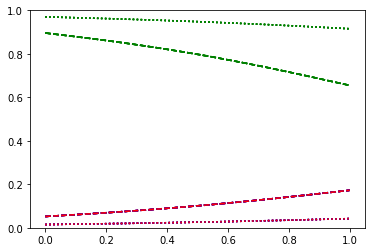

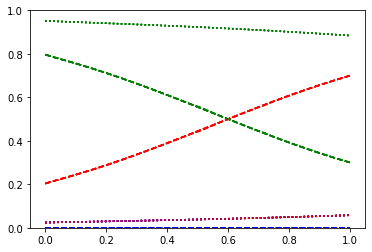

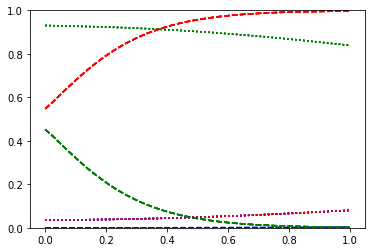

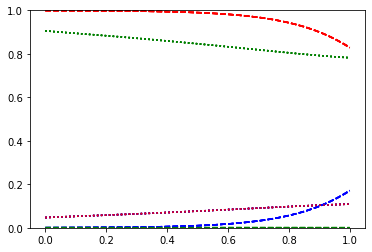

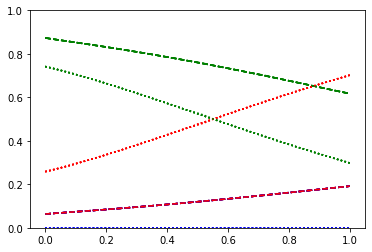

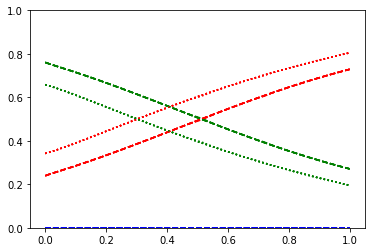

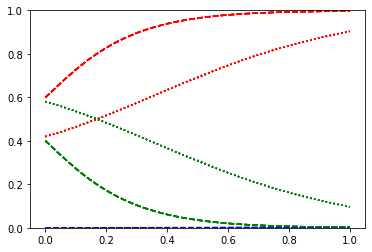

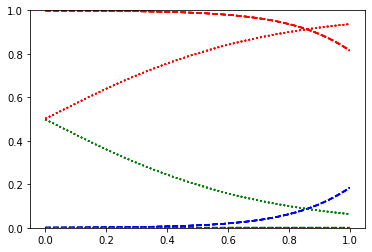

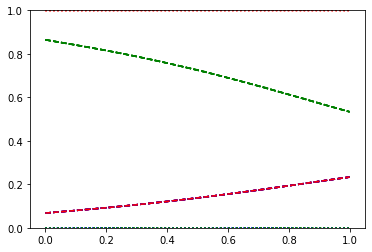

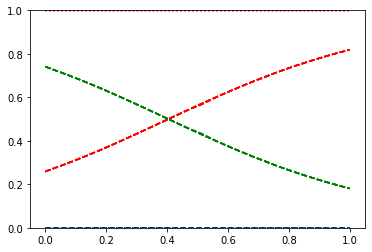

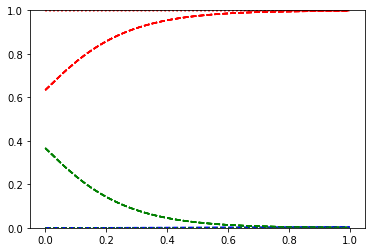

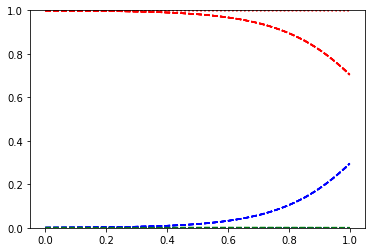

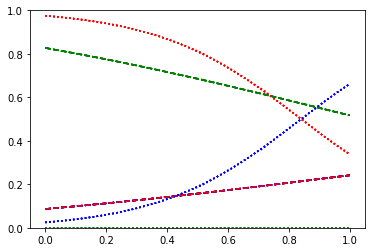

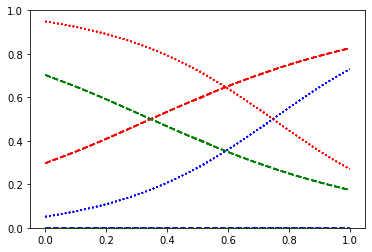

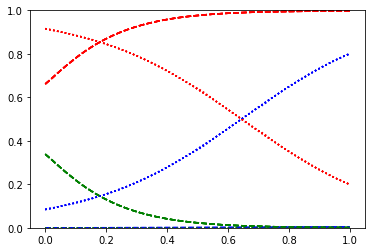

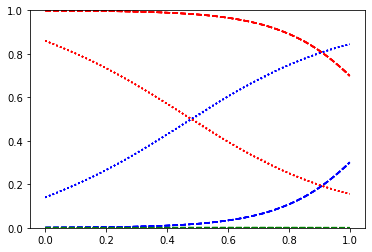

In [6]:
import matplotlib.pyplot as plt
from tqdm import tqdm
discrete_tol = 10*(1+np.array([5,6,7,8,9,10]))
Q1_plot = []
Q2_plot = []
pi1_plot = []
pi2_plot = []
for num_disc in tqdm(discrete_tol):
  x_old_test = np.linspace(0,1,num_disc)
  Q1,Q2,pi1,pi2 = ValuePartial(theta1,num=num_disc)
  Q1_plot.append(Q1)
  Q2_plot.append(Q2)
  pi1_plot.append(pi1)
  pi2_plot.append(pi2)

for so in range(dim_so):
  for i in range(len(discrete_tol)):
    plt.plot(np.linspace(0,1,discrete_tol[i]),pi2_plot[i][:,so,0],'b--')
    plt.plot(np.linspace(0,1,discrete_tol[i]),pi2_plot[i][:,so,1],'r--')
    plt.plot(np.linspace(0,1,discrete_tol[i]),pi2_plot[i][:,so,2],'g--')
  
    plt.plot(np.linspace(0,1,discrete_tol[i]),pi1_plot[i][:,so,0],'b:')
    plt.plot(np.linspace(0,1,discrete_tol[i]),pi1_plot[i][:,so,1],'r:')
    plt.plot(np.linspace(0,1,discrete_tol[i]),pi1_plot[i][:,so,2],'g:')
  plt.ylim(0,1)
  plt.show()

# 3. Data Generation

In [7]:
from tqdm import tqdm
def DataGeneration(theta1 = theta1,theta2=theta2,T=TimePeriod,N=SamplePath,Nsub = Nsub,num=dim_discrete):
  trans,obser,dy_trob = DynamicPartial(theta2)
  _,_,pi1,pi2 = ValuePartial(theta1,theta2 = theta2,num=num)

  hstate = np.zeros([T+1,N],dtype= int)    #hidden state (s^h)
  ostate = np.zeros([T+1,N],dtype = int)  #observalbe state s^o =(n1,n2) -> n1*3+n2
  zstate = np.zeros([T+1,N],dtype = int)   #observation state z
  belief = np.zeros([T+1,N])                #belief x
  action1 = np.zeros([T,N],dtype = int)   #agent1's action
  action2 = np.zeros([T,N],dtype = int)   #agent2's action
  sigma = np.zeros([T,N])

  belief[0,:] = np.kron(np.ones(int(N/Nsub)),np.linspace(0,1,int(Nsub)))#np.random.uniform(size=N)
  hstate[0,:] = np.int_(belief[0,:]<=np.random.random(size=N))#1#np.random.randint(0,dim_sh,size=N) # random generate market type
  zstate_mat = np.random.random(size=N)
  zstate[0,:] = np.int_(obser[hstate[0],0]<=zstate_mat) # random generate income
  ostate[0,:] = 0#np.random.randint(0,dim_so,size=N)

  # action1[0,:] = np.ones(N,dtype = int)   #agent1's action open store (initial n1=0)
  # action2[0,:] = np.ones(N,dtype = int)   #agent2's action open store (initial n2=0)    


  for t in tqdm(range(T)):
    # iterpolate belief
    belief_f = np.floor(belief[t,:] *(num-1))/(num-1)
    belief_c = np.ceil(belief[t,:] *(num-1))/(num-1)
    iterpolate = np.zeros(belief_f.shape)
    iter_n0 = np.where((belief_f-belief_c)!=0)
    iterpolate[iter_n0] = (belief[t,:] -belief_c)[iter_n0]/(belief_f-belief_c)[iter_n0]
    belief_fint,belief_cint = np.int_(belief_f*(num-1)),np.int_(belief_c*(num-1))

    # generate new action for both agents
    os = ostate[t,:]

    action_mat1 = np.random.random(size=N)
    p11 = iterpolate*pi1[belief_fint,os,0] + (1-iterpolate)*pi1[belief_cint,os,0]
    p12 = iterpolate*pi1[belief_fint,os,1] + (1-iterpolate)*pi1[belief_cint,os,1]
    action1[t,:] = np.int_(p11<=action_mat1) + np.int_(p12 + p11 <= action_mat1)
    
    action_mat2 = np.random.random(size=N)
    p21 = iterpolate*pi2[belief_fint,os,0] + (1-iterpolate)*pi2[belief_cint,os,0]
    p22 = iterpolate*pi2[belief_fint,os,1] + (1-iterpolate)*pi2[belief_cint,os,1]
    action2[t,:] = np.int_(p21<=action_mat2) + np.int_(p22 + p21 <= action_mat2)
    
    # generate new hidden state and observation state
    state_mat1 = np.random.random(size=N)
    hstate[t+1,:] = np.int_(trans[hstate[t,:],0]<=state_mat1)

    zstate_mat = np.random.random(size=N)
    zstate[t+1,:] = np.int_(obser[hstate[t+1],0]<=zstate_mat) # random generate income

    ostate[t+1,:] = np.int_(np.where(dy_a1so[action1[t],os,:] * dy_a2so[action2[t],os,:]==1)[1])#n1

    # update new belief
    sigma[t,:],belief[t+1,:],_ = SigmaLambda(theta2,xold = belief[t],znew=zstate[t+1],num=num,T=1)
  return hstate,ostate, zstate,belief,action1,action2,sigma


hstate,ostate, zstate,belief,action1,action2,sigma= DataGeneration()

100%|██████████| 100/100 [00:00<00:00, 1027.12it/s]


In [8]:
print(np.array([np.sum(action1==i) for i in range(dim_a)])/TimePeriod/SamplePath)
print(np.array([np.sum(action2==i) for i in range(dim_a)])/TimePeriod/SamplePath)
print(np.array([np.sum(hstate==i) for i in range(dim_sh)])/(TimePeriod+1)/SamplePath)
print(np.array([np.sum(ostate==i) for i in range(dim_so)])/(TimePeriod+1)/SamplePath)
print(np.array([np.sum(zstate==i) for i in range(dim_z)])/(TimePeriod+1)/SamplePath)

# [0.38001042 0.49154167 0.12844792]
# [0.09610417 0.75103125 0.15286458]
# [0.5023873 0.4976127]
# [0.00634221 0.29677254 0.29152664 0.00592213 0.16026639 0.20493852
#  0.00241803 0.01419057 0.01762295]
# [0.50172131 0.49827869]

[2.92000e-04 9.79672e-01 2.00360e-02]
[0.00756  0.957068 0.035372]
[0.17589307 0.82410693]
[1.00158416e-02 3.52475248e-04 1.98019802e-05 3.96039604e-06
 2.58613861e-03 1.35445545e-02 1.39366337e-02 1.28712871e-03
 3.88118812e-04 1.07722772e-02 1.55897030e-01 7.91065347e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.30693069e-04]
[0.23019406 0.76980594]


In [9]:
sigma_val,_,_ = SigmaLambda(theta2,xold=belief[0],znew=zstate,T=TimePeriod,num=dim_discrete)
np.sum(sigma_val==0),np.sum(sigma==0),np.sum(sigma-sigma_val)

(0, 0, 0.0)

# 4. Recover Process (Partial)

##4.1 Dynmic Recover

In [10]:
theta2

array([0.94  , 0.9919, 0.0827])

In [11]:
2*SamplePath*TimePeriod*2e-8

0.01

In [12]:
from scipy.optimize import minimize
ini_x0= np.array(theta2)*0.85
#ini_x0 = 0.1*np.ones(3)#np.array(theta2) 
print('start from:',ini_x0 )
def func1(theta2, data_bz=zstate,data_x0= belief[0],T=TimePeriod,num=dim_discrete ):
  sigma_val,_,_ = SigmaLambda(theta2,xold=data_x0,znew=data_bz,T=T,num=num)
  res = -np.sum(np.log(sigma_val))
  if np.isnan(res):
    res=np.inf
  print(theta2,res)
  return res/(2*SamplePath*TimePeriod)

cons = ({'type': 'ineq', 'fun': lambda x:  x[0] -lower_bound},
        {'type': 'ineq', 'fun': lambda x:  1 -x[0] -lower_bound},
        {'type': 'ineq', 'fun': lambda x:  x[1] -lower_bound},
        {'type': 'ineq', 'fun': lambda x:  1 -x[1] -lower_bound},
        {'type': 'ineq', 'fun': lambda x:  x[2] -lower_bound},
        {'type': 'ineq', 'fun': lambda x:  1 -x[2] -lower_bound})
res11 = minimize(func1,ini_x0,constraints = cons, options={'maxiter':4000},tol=1e-5)

print(res11,res11.fun*2*SamplePath*TimePeriod)

start from: [0.799    0.843115 0.070295]
[0.799    0.843115 0.070295] 106969.16521957351
[0.79900001 0.843115   0.070295  ] 106969.16530490335
[0.799      0.84311501 0.070295  ] 106969.16291871175
[0.799      0.843115   0.07029501] 106969.166182755
[7.87547223e-01 9.99900000e-01 1.00000000e-04] 197602.34052639673
[0.79761872 0.86202434 0.061829  ] 103681.02456533004
[0.79761873 0.86202434 0.061829  ] 103681.0246219405
[0.79761872 0.86202435 0.061829  ] 103681.02242243249
[0.79761872 0.86202434 0.06182902] 103681.02520280231
[0.79458825 0.9999     0.07045566] 96068.68460228192
[0.79458827 0.9999     0.07045566] 96068.6840119275
[0.79458825 0.99990001 0.07045566] 96068.85714882631
[0.79458825 0.9999     0.07045567] 96068.68369416964
[0.79527565 0.86340744 0.03142188] 103291.72071328381
[0.79493038 0.93196465 0.05102769] 94943.44302865336
[0.79475956 0.9658836  0.06072774] 91754.70087865565
[0.79467486 0.98270317 0.06553775] 90866.6971630933
[0.79463272 0.99107059 0.06793064] 90978.357483

##4.2 Reward Recover

In [13]:
theta1

array([ 6.3, -1.5, -1. , -0.4, 12.5,  3.2, -0.7, -0.3, -0.2,  7.7])

In [14]:
norm_theta1 = 10#np.max(theta1)
ini_x0 = theta1/norm_theta1
# ini_x0 = np.array([1.9, -2.2, -0.4, 10.7, 12.5,
#                    1.2, -0.5, -0.2 ,  5.2,7.7])#np.array([theta1[0],theta1[1],theta1[2],theta1[4],theta1[5],
#          #              theta1[6],theta1[7],theta1[8],theta1[10],theta1[11]])
print('start from:',ini_x0*norm_theta1 )

_,belief_val,_ = SigmaLambda(res11.x,xold=belief[0],znew=zstate,T=TimePeriod,num=dim_discrete)
def func2(theta1,theta2=res11.x,belief_val=belief_val[0:-1],data_a1=action1,data_a2=action2,data_os=ostate[0:-1],T=TimePeriod,num=dim_discrete):
  # theta1 = np.array([theta1[0],theta1[1],theta1[2],1,theta1[3],theta1[4],
  #                    theta1[5],theta1[6],theta1[7],0,theta1[8],theta1[9]])  
 
  _,_,pi1,pi2 = ValuePartial(theta1*norm_theta1,theta2=theta2,num=num) #xt,st^o,z,a1
  
  belief_f = np.floor(belief_val*(num-1))/(num-1)
  belief_c = np.ceil(belief_val*(num-1))/(num-1)
  iterpolate = np.zeros(belief_f.shape)
  iter_n0 = np.where((belief_f-belief_c)!=0)
  iterpolate[iter_n0] = (belief_val-belief_c)[iter_n0]/(belief_f-belief_c)[iter_n0]      
  belief_f,belief_c = np.int_(belief_f*(num-1)),np.int_(belief_c*(num-1))

  p1 = iterpolate*pi1[belief_f,data_os,data_a1] +(1- iterpolate)*pi1[belief_c,data_os,data_a1]
  p2 = iterpolate*pi2[belief_f,data_os,data_a2] +(1- iterpolate)*pi2[belief_c,data_os,data_a2]
  res = - np.sum(np.log(p1[np.where(p1!=0)])) -np.sum(np.log(p2[np.where(p2!=0)]))
  print(theta1*norm_theta1,res)
  return res/(2*TimePeriod*SamplePath)

#res12 = func2(ini_x0)
import time
start = time.time()
res12 = minimize(func2,ini_x0,options={'maxiter':4000},tol=1e-4)#,constraints = cons), method = 'Nelder-Mead'
print(time.time()-start)
print(res12)
print(res12.x*norm_theta1,res12.fun*2*TimePeriod*SamplePath)

start from: [ 6.3 -1.5 -1.  -0.4 12.5  3.2 -0.7 -0.3 -0.2  7.7]
[ 6.3 -1.5 -1.  -0.4 12.5  3.2 -0.7 -0.3 -0.2  7.7] 23830.55284507198
[ 6.30000015 -1.5        -1.         -0.4        12.5         3.2
 -0.7        -0.3        -0.2         7.7       ] 23830.552843603706
[ 6.3        -1.49999985 -1.         -0.4        12.5         3.2
 -0.7        -0.3        -0.2         7.7       ] 23830.55284495803
[ 6.3        -1.5        -0.99999985 -0.4        12.5         3.2
 -0.7        -0.3        -0.2         7.7       ] 23830.552846707502
[ 6.3        -1.5        -1.         -0.39999985 12.5         3.2
 -0.7        -0.3        -0.2         7.7       ] 23830.55284345463
[ 6.3        -1.5        -1.         -0.4        12.50000015  3.2
 -0.7        -0.3        -0.2         7.7       ] 23830.552845576076
[ 6.3        -1.5        -1.         -0.4        12.5         3.20000015
 -0.7        -0.3        -0.2         7.7       ] 23830.552836991388
[ 6.3        -1.5        -1.         -0.4        12

In [16]:
norm_theta1 = 1#np.max(theta1)
ini_x0 = theta1*0.85/norm_theta1
# ini_x0 = np.array([-0.16882462 ,-0.2414883 , -0.12569695 , 0.44309512  ,3.39059685 , 1.8553294,
#   0.48548591  ,0.56140381 ,-1.34535218  ,0.15616967])
# ini_x0 = np.array([1.9, -2.2, -0.4, 10.7, 12.5,
#                    1.2, -0.5, -0.2 ,  5.2,7.7])#np.array([theta1[0],theta1[1],theta1[2],theta1[4],theta1[5],
#          #              theta1[6],theta1[7],theta1[8],theta1[10],theta1[11]])
print('start from:',ini_x0*norm_theta1 )

_,belief_val,_ = SigmaLambda(res11.x,xold=belief[0],znew=zstate,T=TimePeriod,num=dim_discrete)
def func2(theta1,theta2=res11.x,belief_val=belief_val[0:-1],data_a1=action1,data_a2=action2,data_os=ostate[0:-1],T=TimePeriod,num=dim_discrete):
  # theta1 = np.array([theta1[0],theta1[1],theta1[2],1,theta1[3],theta1[4],
  #                    theta1[5],theta1[6],theta1[7],0,theta1[8],theta1[9]])  
 
  _,_,pi1,pi2 = ValuePartial(theta1*norm_theta1,theta2=theta2,num=num) #xt,st^o,z,a1
  
  belief_f = np.floor(belief_val*(num-1))/(num-1)
  belief_c = np.ceil(belief_val*(num-1))/(num-1)
  iterpolate = np.zeros(belief_f.shape)
  iter_n0 = np.where((belief_f-belief_c)!=0)
  iterpolate[iter_n0] = (belief_val-belief_c)[iter_n0]/(belief_f-belief_c)[iter_n0]      
  belief_f,belief_c = np.int_(belief_f*(num-1)),np.int_(belief_c*(num-1))

  p1 = iterpolate*pi1[belief_f,data_os,data_a1] +(1- iterpolate)*pi1[belief_c,data_os,data_a1]
  p2 = iterpolate*pi2[belief_f,data_os,data_a2] +(1- iterpolate)*pi2[belief_c,data_os,data_a2]
  res = - np.sum(np.log(p1[np.where(p1!=0)])) -np.sum(np.log(p2[np.where(p2!=0)]))
  print(theta1*norm_theta1,res)
  return res#/(2*TimePeriod*SamplePath)

#res12 = func2(ini_x0)
import time
start = time.time()
res12 = minimize(func2,ini_x0,options={'maxiter':4000},tol=1e-4)#,constraints = cons), method = 'Nelder-Mead'
print(time.time()-start)
print(res12)
print(res12.x*norm_theta1,res12.fun)#*2*TimePeriod*SamplePath)

start from: [ 5.355 -1.275 -0.85  -0.34  10.625  2.72  -0.595 -0.255 -0.17   6.545]
[ 5.355 -1.275 -0.85  -0.34  10.625  2.72  -0.595 -0.255 -0.17   6.545] 24301.822860306893
[ 5.35500001 -1.275      -0.85       -0.34       10.625       2.72
 -0.595      -0.255      -0.17        6.545     ] 24301.822857732357
[ 5.355      -1.27499999 -0.85       -0.34       10.625       2.72
 -0.595      -0.255      -0.17        6.545     ] 24301.822860955872
[ 5.355      -1.275      -0.84999999 -0.34       10.625       2.72
 -0.595      -0.255      -0.17        6.545     ] 24301.822857891362
[ 5.355      -1.275      -0.85       -0.33999999 10.625       2.72
 -0.595      -0.255      -0.17        6.545     ] 24301.82285981014
[ 5.355      -1.275      -0.85       -0.34       10.62500001  2.72
 -0.595      -0.255      -0.17        6.545     ] 24301.822860249726
[ 5.355      -1.275      -0.85       -0.34       10.625       2.72000001
 -0.595      -0.255      -0.17        6.545     ] 24301.822824401468
[ 5.

#5. Save

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# import pickle
# res = { 'hstate':hstate,'ostate':ostate, 'zstate':zstate,'belief':belief,'action1':action1,'action2':action2,'sigma':sigma}
# filename = '/content/drive/MyDrive/2021_FALL/Data_Game_BurgerKing/code/Burger_Simulation/'

# with open(filename + 'highdim.txt','wb') as fp:
#   pickle.dump(res,fp)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

xx = np.array([-1,0,1,2])
yy = np.array([7.55408382,8.475704,9.47704787,10.47931287])
error = np.array([150292.35587482594, 150291.83268033605,150291.83268573694, 150291.83320348617])

plt.plot(xx,yy,'b+')
plt.show()
plt.plot(xx,error,'r+')